# Anomalies
### Authors

Fletcher Hozven fhozven@ucsb.edu

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import required packages](#import)

[Open the NetCDF File and Format Time Information](#open)

[Spatial Average Over the Selected Region](#spatial)

[Calculate Anomalies: Baseline Removal](#anom_base)

[Calculate Anomalies: Seasonal Climatology Removal](#anom_clim)

[Plot the Anomalies!](#plot)

<a id='purpose'></a> 
## **Goals**

For this tutorial, we are going to calculate the anomalies of our desired climate data variable and plot them! Anomalies are frequently used in climate science, and it is crucial to understand what an anomaly is when analyzing your climate data.

_What is an Anomaly?_

In climate science, an "anomaly" refers to the deviation of a measured climate variable (like temperature or precipitation) from an average for a specific location and time period. A positive anomaly indicates a value higher than the average, while a negative anomaly indicates a value lower than the average. 

_How to calculate an Anomaly ?_

Generally, an anomaly is the difference between an actual value and some long-term average value.

For example if ...
- X = actual value of average temperature for January, 1982 
- Xbar = long-term average temperature for January (an average over many years)
- anom = anomaly value for January, 1982

Then the anomaly is equal to X - Xbar.

Here we will use two commonly employed methods of calculating the long-term average:
1) the _overall_ mean value over some relatively long "baseline" period; and
2) the _seasonally varying_ mean.

Method 1 is often used for things like global average temperature: see the below example plot from [NOAA](https://www.ncei.noaa.gov/news/noaa-updates-its-global-surface-temperature-dataset). However, it does not remove the effects of the seasonal cycle, which can sometimes make it difficult to see changes on longer timescales: Method 2 is therefore also used sometimes. Here we'll explore both!


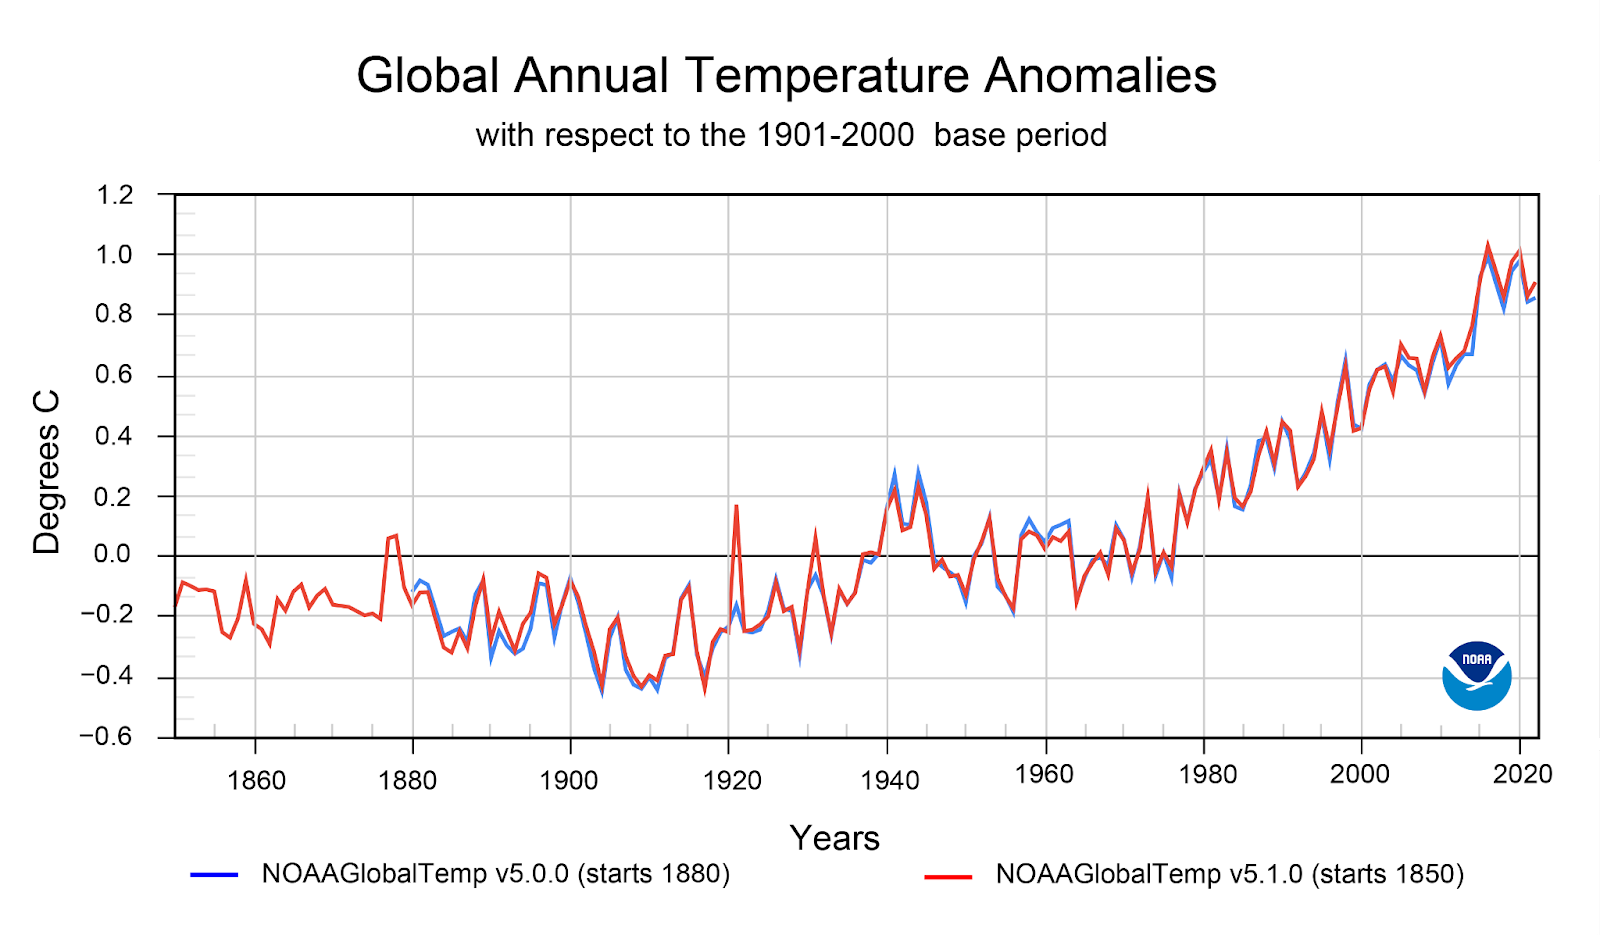

<a id='Import'></a> 
## **Import Required Packages**

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

<a id='Path'></a> 
## **Open the NetCDF File and Format Time Information**

As in the previous tutorials, we'll work with the surface air temperature from a historical simulation run with CanESM5:

In [3]:
data = xr.open_dataset('/Users/samstevenson/Box Sync/Climate_DataLab/tas_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc')
data

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/53)
    CCCma_model_hash:            55f484f90aff0e32c5a8e92a42c6b9ae7ffe6224
    CCCma_parent_runid:          rc3.1-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his10
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/5ed65f32-a352-4bd1-83a4-c659b4f...
    variable_id:                 tas
    variant_label:               r10i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

We again define an xarray DataArray containing only the "tas" variable, and convert the time format to Numpy datetime64:

In [5]:
tas = data.tas
time= data.time.astype('datetime64[ns]')

<a id='spatial'></a> 
## **Spatial Average Over the Selected Region** 
__Lets choose New York City like our previous tutorials.__

A) Define the latitude and longitude bounds for New York City¶
- This code snippet is setting up two pairs of variables, `lat_min` and `lat_max` for latitude, and `lon_min` and `lon_max` for longitude.
- These variables are used to define a specific geographic region of interest within a broader dataset
- You can use a map or a globe to determine the approximate latitude and longitude boundaries of the region you're interested in. Here we're using a relatively large box since the CanESM5 grid spacing is fairly coarse.

In [6]:
# Define min/max bounds for region of interest (NYC)
lat_min, lat_max = 40, 41.5
lon_min, lon_max = 285.5, 287

B) Subset the Data for New York City
- The code defines latitude and longitude masks for New York City using the `tas` dataset.
- The masks (`tas_NYC_lat` and `tas_NYC_lon`) filter the dataset to include only the grid cells within the specified latitude (`lat_min` to `lat_max`) and longitude (`lon_min` to `lon_max`) boundaries.
- Finally, the `tas.where()` function is used to subset the data to the specified region, dropping any data points outside the specified latitude and longitude range.

In [7]:
tas_NYC_lat = (tas.lat >= lat_min) & (tas.lat <= lat_max)
tas_NYC_lon = (tas.lon >= lon_min) & (tas.lon <= lon_max)
tas_NYC = tas.where(tas_NYC_lat & tas_NYC_lon, drop=True)

- `tas_NYC` filtered temperature data for New York City.
- `.mean(dim=['lat', 'lon'])`Averages the temperature data over all the latitude and longitude points in the NYC region that was set in the pervious step
- The result is a single average temperature value for each time step.

In [9]:
tas_NYC = tas_NYC.mean(dim=['lat','lon'])

<a id='anom_base'></a> 
## **Calculate and Plot Anomalies: Baseline Removal**  

Anomaly calculation using the baseline removal method is shown first. The first step is to select the time period you want to use as the baseline. For mine I am using 1990-2010. 

__NOTE: Make sure your chosen time period is available in your climate data!__ You can see this when you print the data.

In the code block below:
- `.sel` selects a specific variable from your data
- `time=slice()` is a function to slice the desired time from your climate data

In [10]:
# Define long-term baseline 
baseline_sel = tas_NYC.sel(time=slice("1990-01-01", "2010-12-31"))

Then we simply remove the average over the baseline period from the input time series:

In [24]:
# Calculate anomaly by removing baseline
anom_base = tas_NYC - baseline_sel.mean()

Now let's plot the results!

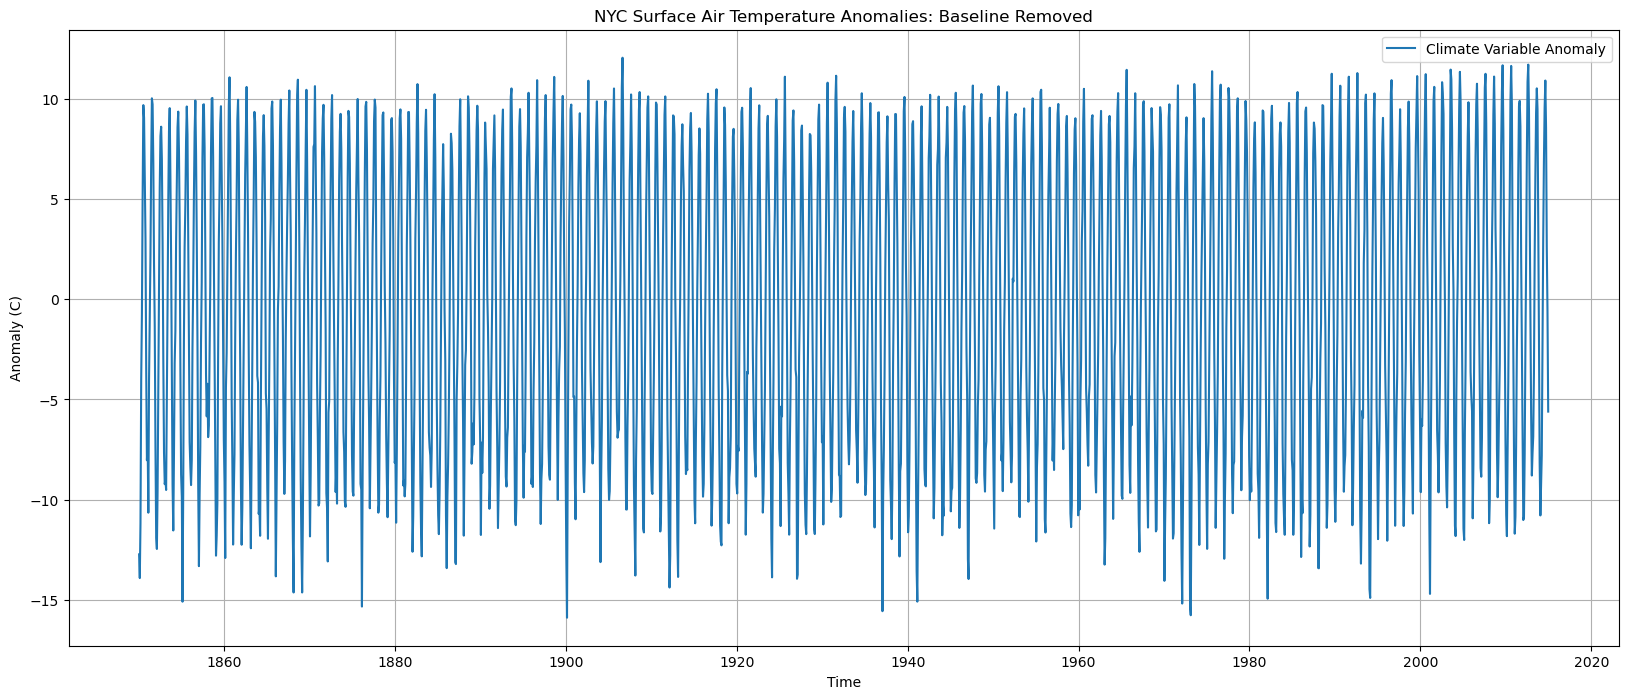

In [18]:
# Plot anomalies: baseline removal method
plt.figure(figsize=(20, 8))
plt.plot(time, anom_base, label="Climate Variable Anomaly")
plt.xlabel("Time")
plt.ylabel("Anomaly (C)")
plt.title("NYC Surface Air Temperature Anomalies: Baseline Removed")
plt.legend()
plt.grid()
plt.show()

As you can see, there is a strong periodicity to the anomalies plotted above: this is because the _seasonal cycle_ is still included in the data. We can get around this by creating an annual average and plotting again: for details on how to perform the annual averaing, see tutorial 2 in this repo.

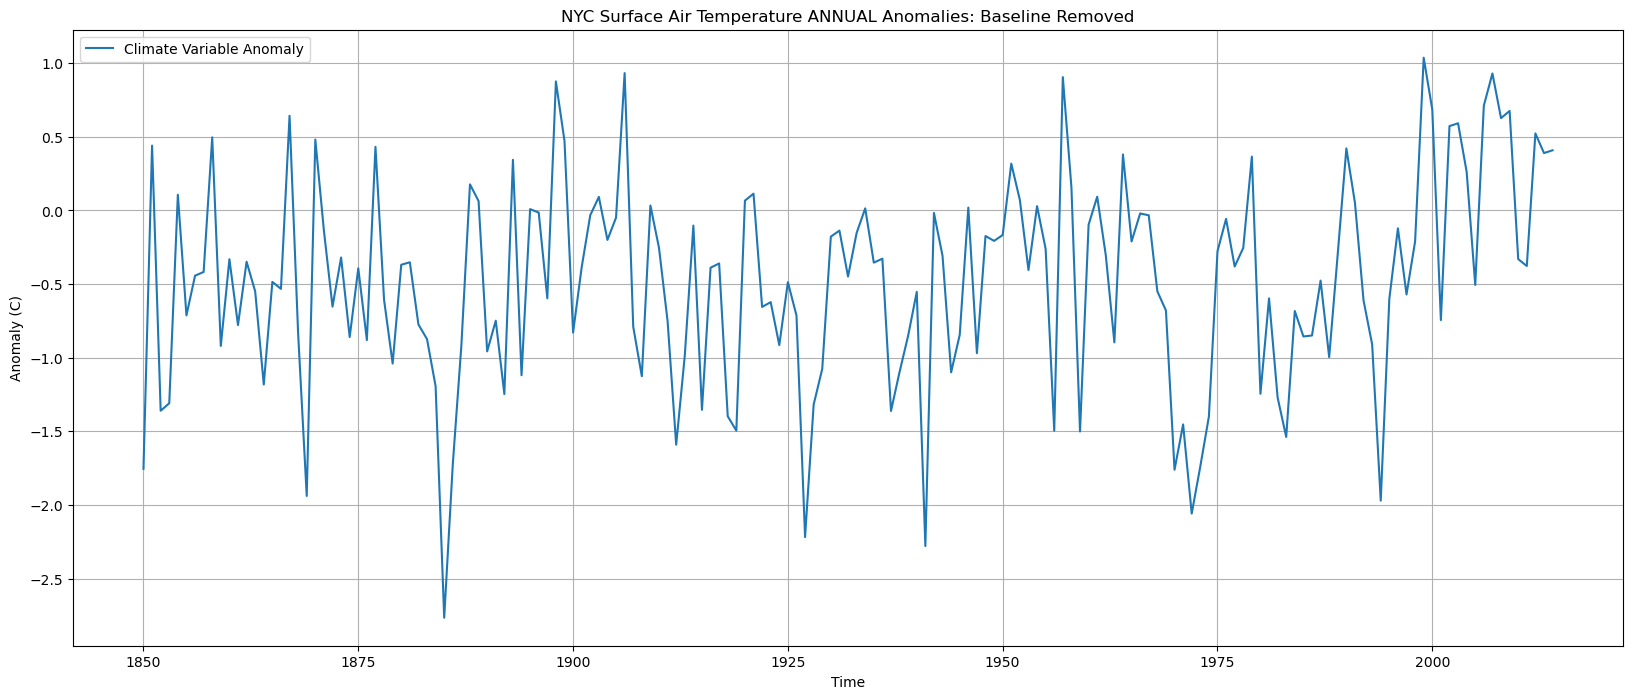

In [27]:
# calculate annual average of anomalies
anom_base = anom_base.groupby("time.year").mean("time")

# Plot ANNUAL anomalies: baseline removal method
plt.figure(figsize=(20, 8))
plt.plot(anom_base.year, anom_base, label="Climate Variable Anomaly")
plt.xlabel("Time")
plt.ylabel("Anomaly (C)")
plt.title("NYC Surface Air Temperature ANNUAL Anomalies: Baseline Removed")
plt.legend()
plt.grid()
plt.show()

Now it's easier to see the variations in the time series - but the annual averaging means that we no longer have the ability to look at different months. This is where the second method of calculating anomalies can be helpful.

<a id='anom_clim'></a> 
## Calculate Anomalies: Seasonal Climatology Removal

In the second anomaly calculation method, we start by computing the mean of the data according to month (the time resolution of the input data file): this is often referred to as the _seasonal climatology_. 

In [28]:
baseline = baseline_sel.groupby("time.month").mean("time")
baseline

<xarray.DataArray 'tas' (month: 12)>
array([277.7773 , 277.82602, 281.5303 , 284.95236, 290.11655, 294.07025,
       297.5565 , 298.79663, 296.1785 , 291.20093, 285.9911 , 281.31613],
      dtype=float32)
Coordinates:
    height   float64 2.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Again, that baseline is removed from the data:

In [29]:
anomaly = tas_NYC.groupby("time.month") - baseline
anomaly

<xarray.DataArray 'tas' (time: 1980)>
array([-2.3923645 , -3.6233215 , -4.5878296 , ..., -0.47323608,
        1.5418091 ,  1.1867065 ], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    height   float64 2.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

Now we can take a look at the results!

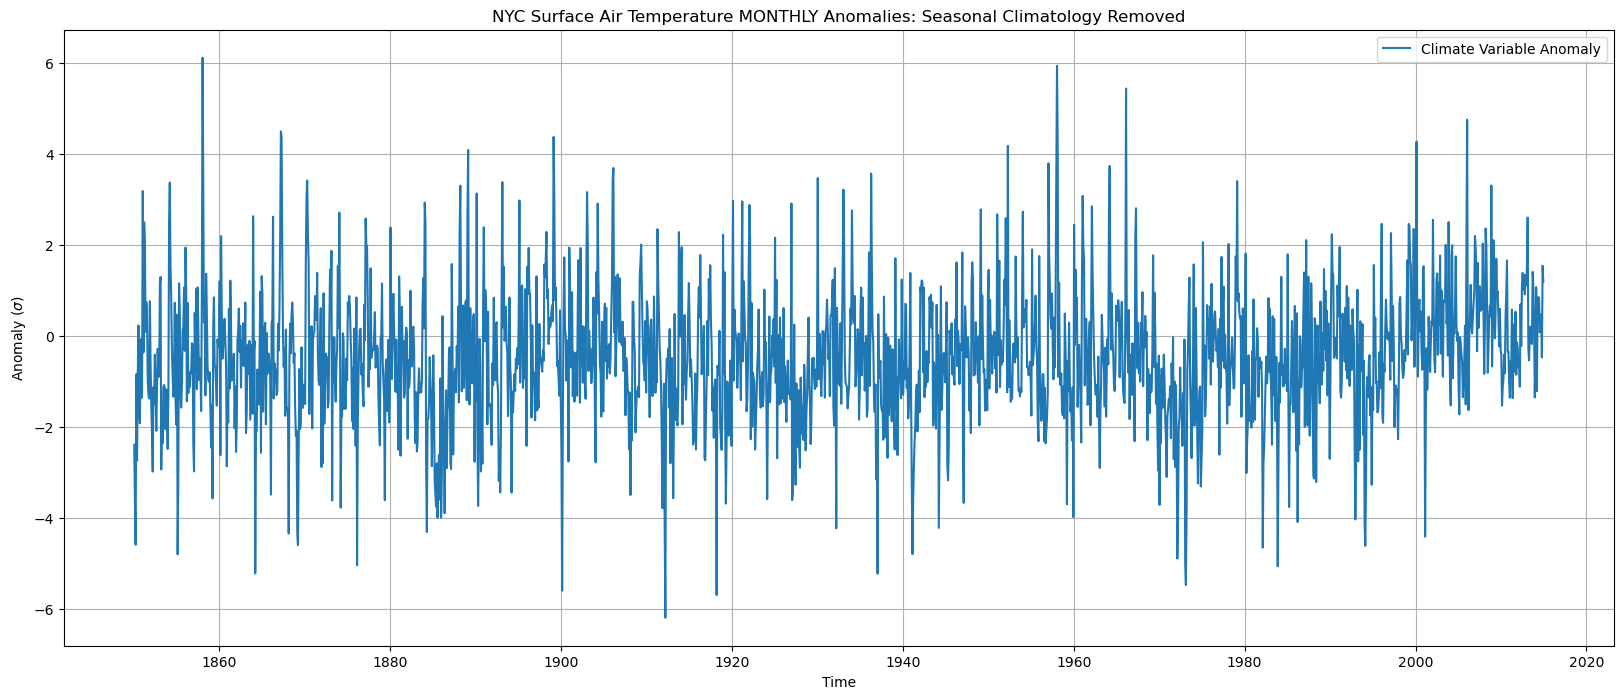

In [31]:
plt.figure(figsize=(20, 8))
plt.plot(time, anomaly, label="Climate Variable Anomaly")
plt.xlabel("Time")
plt.ylabel("Anomaly ($\sigma$)")
plt.title("NYC Surface Air Temperature MONTHLY Anomalies: Seasonal Climatology Removed")
plt.legend()
plt.grid()
plt.show()

This plot looks similar to the plot of annual temperature anomalies above, but with much more variation since individual months are still present in the data. Which method you choose can depend on your application, but now you have some options!